In [ ]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from PIL import Image
#from keras.preprocessing.image import img_to_array
import numpy as np
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/content/drive/MyDrive/DATASET/HR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = np.array(Image.fromarray(img).resize((SIZE, SIZE))) / 255.0
        high_img.append(img)   
low_img = []
path = '/content/drive/MyDrive/DATASET/LR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = np.array(Image.fromarray(img).resize((SIZE, SIZE))) / 255.0
        low_img.append(img)

100%|██████████| 855/855 [00:07<00:00, 115.23it/s]


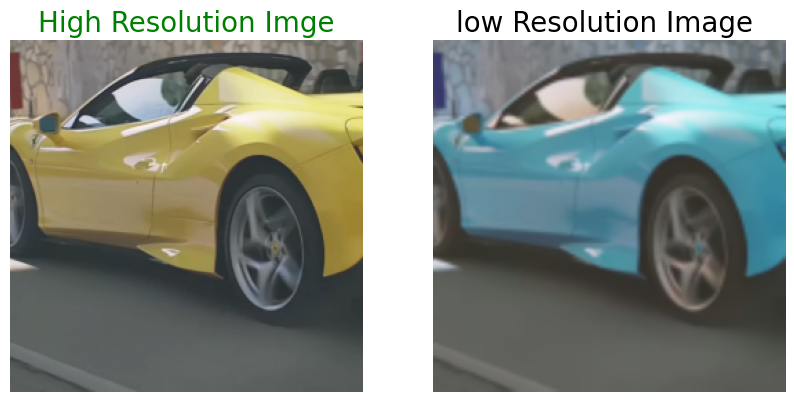

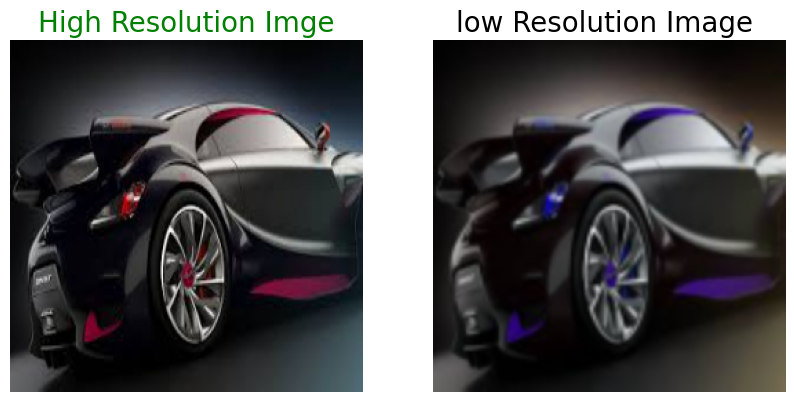

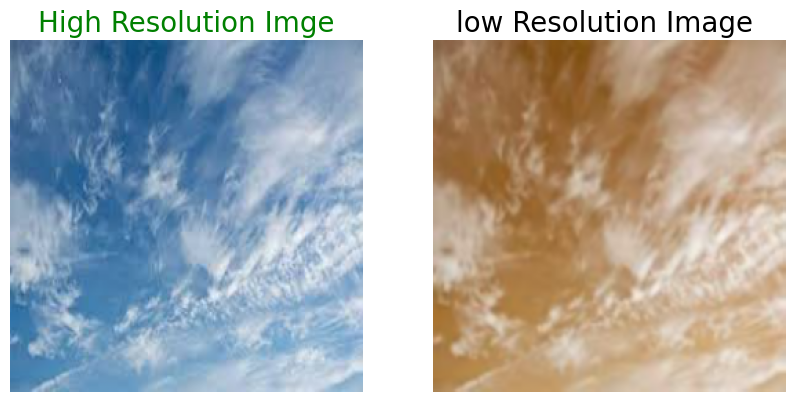

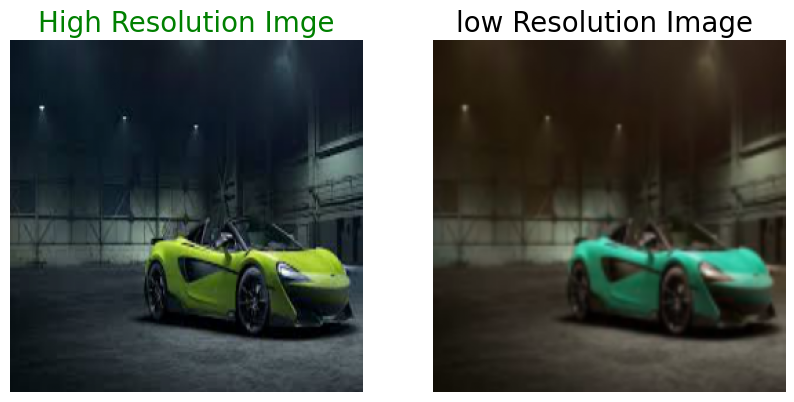

In [ ]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [ ]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample
    
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [ ]:
model.fit(train_low_image, train_high_image, epochs = 7, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/7
700/700 [==============================] - 526s 751ms/step - loss: 0.0247 - acc: 0.8045 - val_loss: 0.0213 - val_acc: 0.8087
Epoch 3/7
700/700 [==============================] - 526s 752ms/step - loss: 0.0208 - acc: 0.8318 - val_loss: 0.0204 - val_acc: 0.8577
Epoch 4/7
700/700 [==============================] - 538s 769ms/step - loss: 0.0201 - acc: 0.8378 - val_loss: 0.0196 - val_acc: 0.8878
Epoch 5/7
700/700 [==============================] - 527s 753ms/step - loss: 0.0191 - acc: 0.8412 - val_loss: 0.0202 - val_acc: 0.8920
Epoch 6/7
700/700 [==============================] - 538s 768ms/step - loss: 0.0188 - acc: 0.8457 - val_loss: 0.0186 - val_acc: 0.8279
Epoch 7/7
700/700 [==============================] - 532s 760ms/step - loss: 0.0187 - acc: 0.8437 - val_loss: 0.0184 - val_acc: 0.8967


In [ ]:
print(test_low_image[1])  # Verify that this index is valid

[[[0.1372549  0.10980392 0.09803922]
  [0.1372549  0.10980392 0.09803922]
  [0.15294118 0.11764706 0.10980392]
  ...
  [0.15294118 0.16862745 0.17254902]
  [0.16862745 0.18039216 0.18039216]
  [0.16862745 0.18039216 0.18039216]]

 [[0.1372549  0.10980392 0.09803922]
  [0.1372549  0.10980392 0.09803922]
  [0.15294118 0.11764706 0.10980392]
  ...
  [0.15294118 0.16862745 0.17254902]
  [0.16862745 0.18039216 0.18039216]
  [0.16862745 0.18039216 0.18039216]]

 [[0.1372549  0.10980392 0.09803922]
  [0.1372549  0.10980392 0.09803922]
  [0.15686275 0.12156863 0.11372549]
  ...
  [0.19215686 0.20392157 0.2       ]
  [0.2        0.21960784 0.21568627]
  [0.2        0.21960784 0.21568627]]

 ...

 [[0.56078431 0.55294118 0.50588235]
  [0.56078431 0.55294118 0.50588235]
  [0.56078431 0.55686275 0.50980392]
  ...
  [0.43921569 0.4745098  0.44313725]
  [0.43921569 0.47843137 0.44313725]
  [0.43921569 0.47843137 0.44313725]]

 [[0.55686275 0.54901961 0.50196078]
  [0.55686275 0.54901961 0.50196078]


1/1 [==============================] - 0s 487ms/step


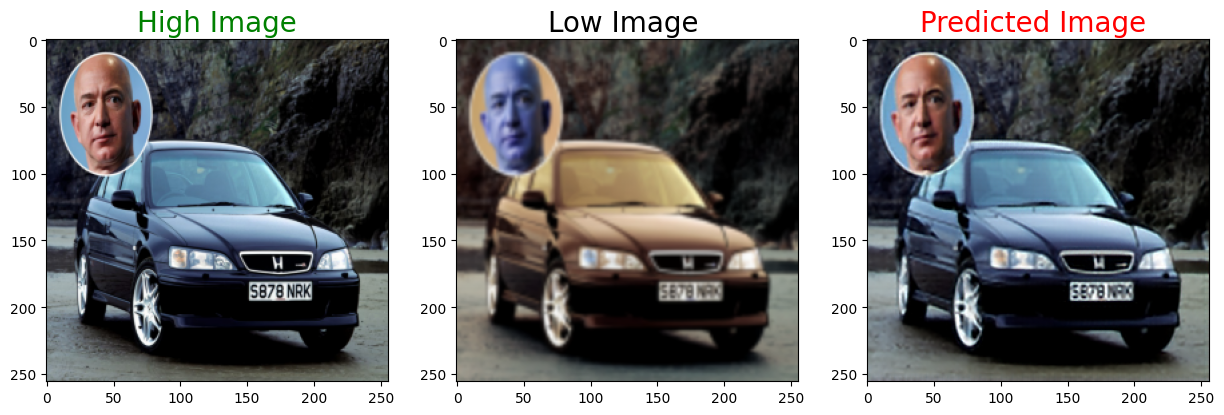

1/1 [==============================] - 0s 344ms/step


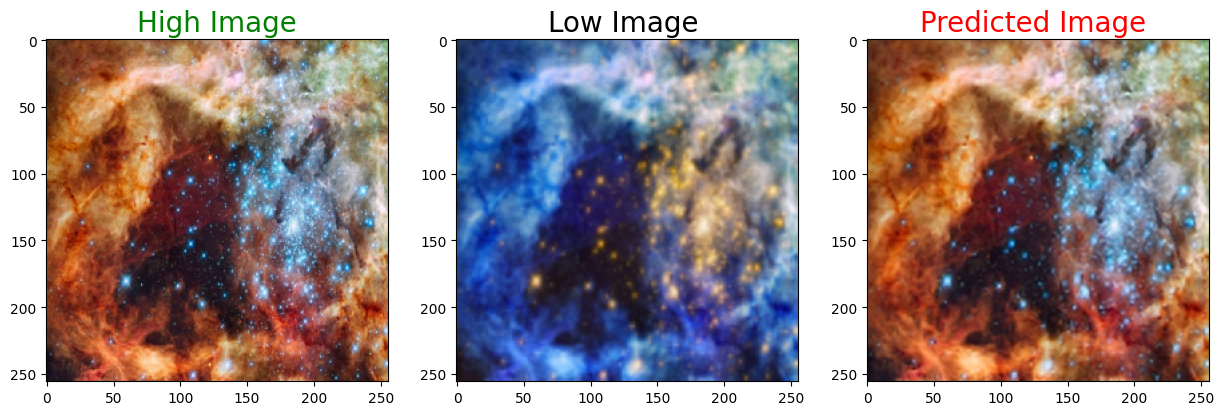

1/1 [==============================] - 0s 358ms/step


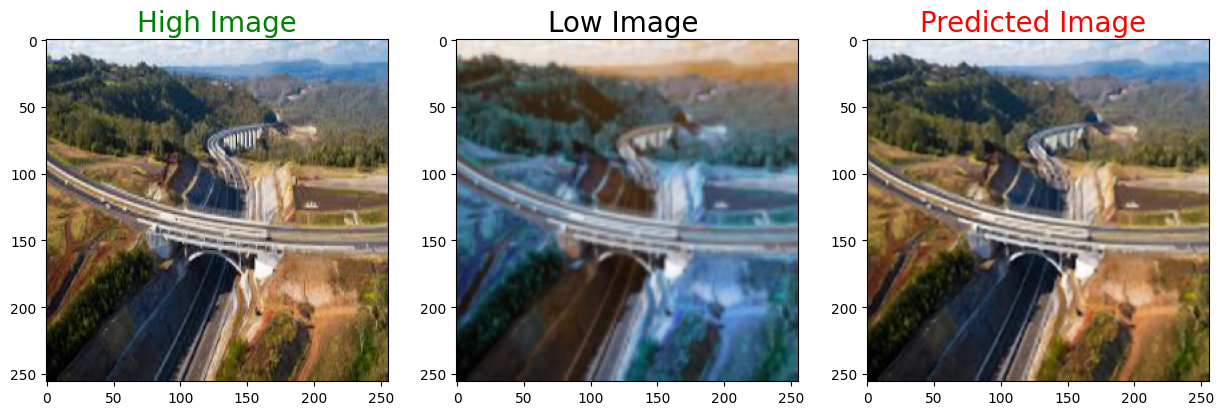

1/1 [==============================] - 0s 309ms/step


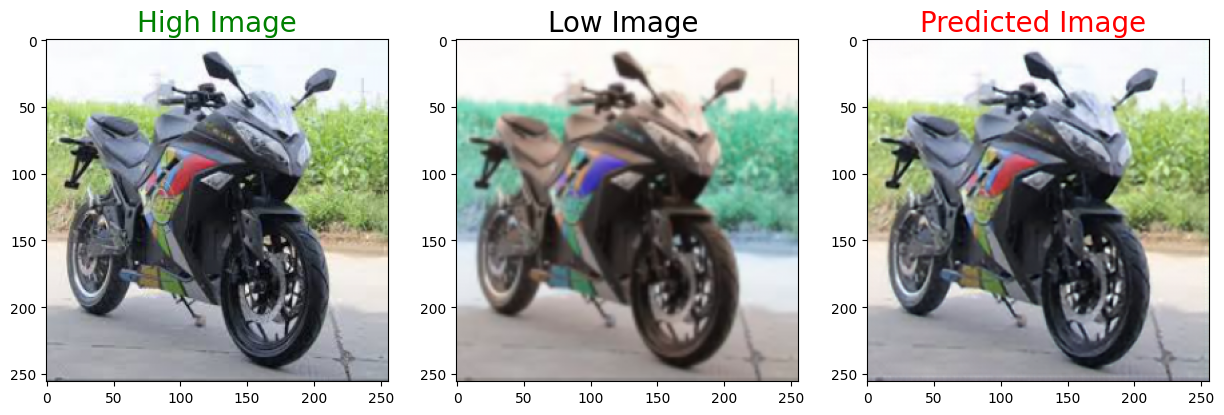

1/1 [==============================] - 0s 451ms/step


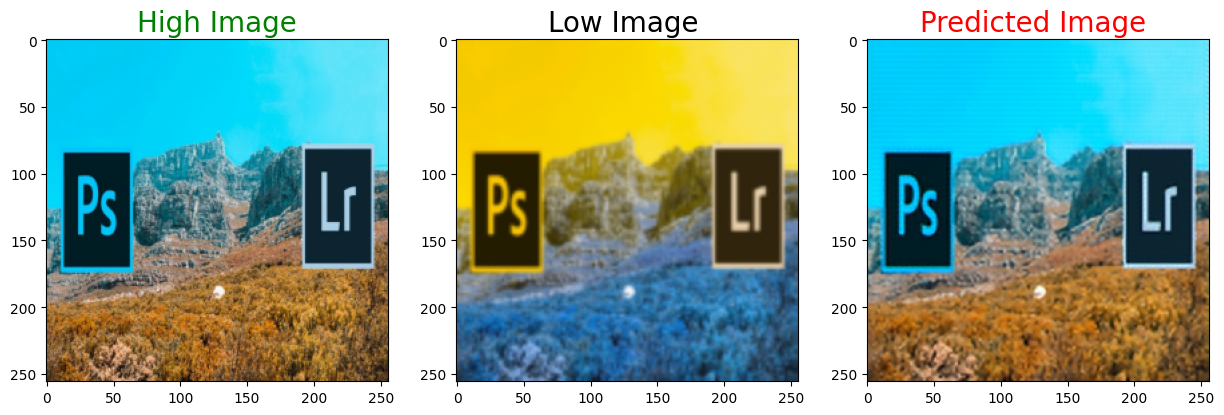

1/1 [==============================] - 1s 588ms/step


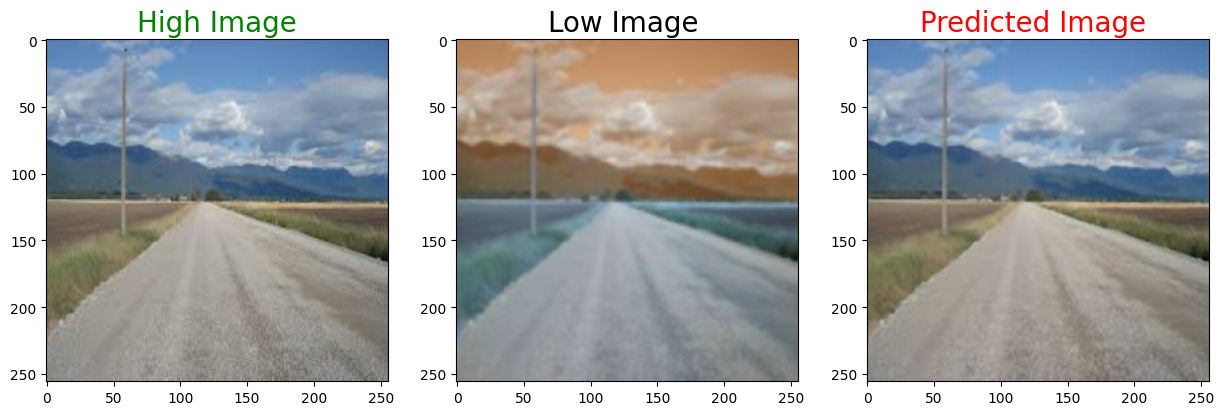

1/1 [==============================] - 0s 491ms/step


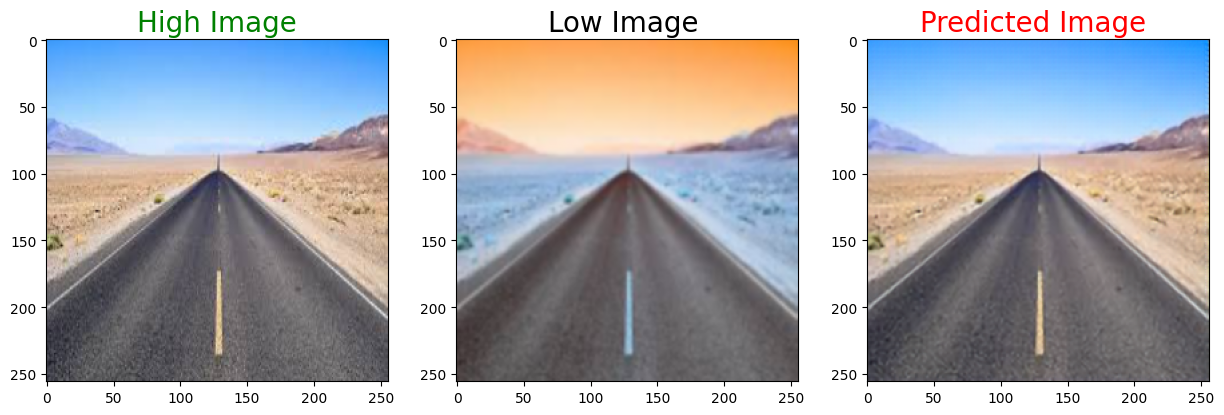

1/1 [==============================] - 0s 370ms/step


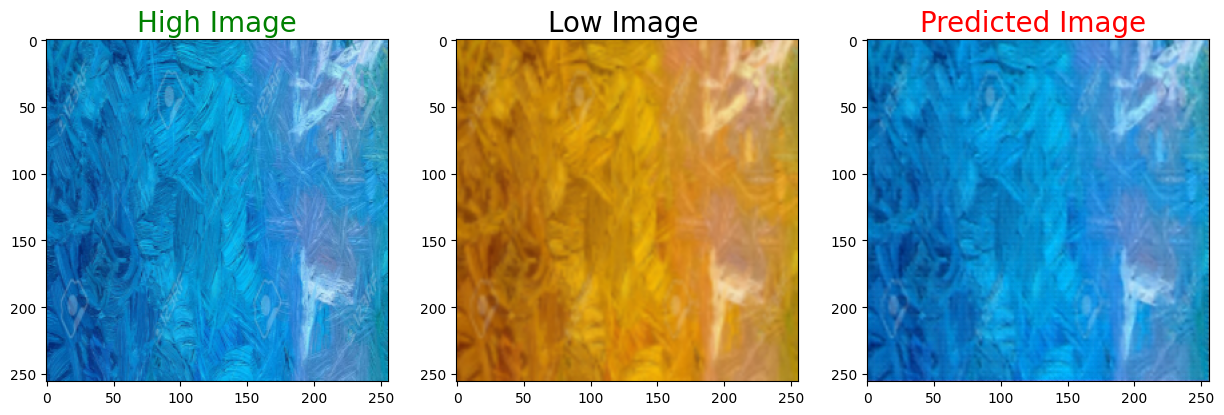

1/1 [==============================] - 0s 425ms/step


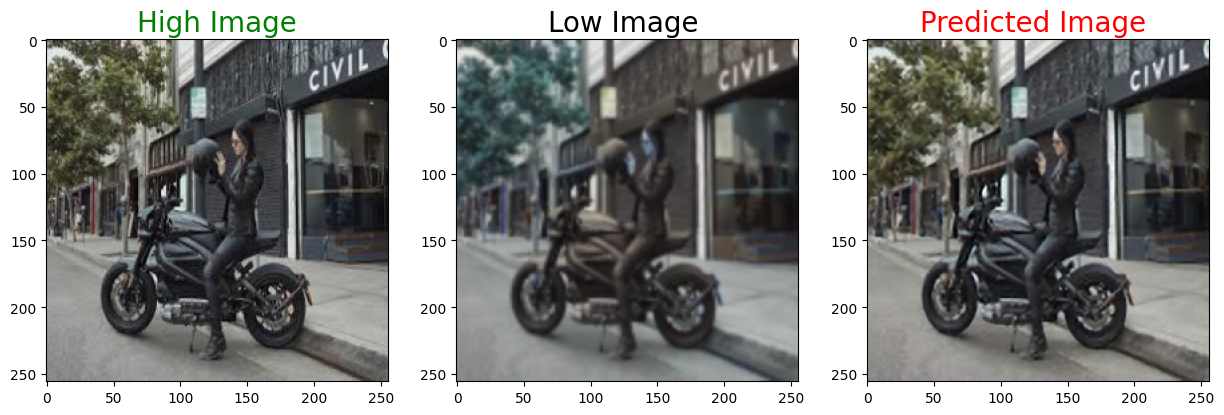

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [ ]:
model.save("/content/drive/MyDrive/Model/final_model.h5")

In [ ]:
import cv2
import keras
import numpy as np

# Load the final_model.h5 model
model = keras.models.load_model('/content/drive/MyDrive/Model/final_model.h5')

# Load the input image
img = cv2.imread('/content/drive/MyDrive/Crowd_images/img5.jpg')

# Preprocess the input image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255.0

# Pass the preprocessed image to the model to get the upscaled image
upscaled_img = model.predict(img[np.newaxis, ...])[0]

# Postprocess the upscaled image
upscaled_img = (upscaled_img * 255.0).astype(np.uint8)
upscaled_img = cv2.resize(upscaled_img, (img.shape[1], img.shape[0]))

# Save or display the upscaled image
cv2.imwrite('/content/drive/MyDrive/Crowd_images/05.jpg', upscaled_img)
cv2.waitKey(0)
cv2.destroyAllWindows()



1/1 [==============================] - 1s 576ms/step
